# Scaled Simulation with Model-Based Control

This notebook runs a scaled marine‐vessel simulation with a PD-style model-based controller and thrust allocation.


In [1]:
import torch
import numpy as np

from torch_core.gym.mc_gym_csad_torch import McGym
from torch_core.controllers.model_based import ModelController
from torch_core.allocations.allocation_psudo import PseudoInverseAllocator
from torch_core.thruster.thruster_data import ThrusterData
from torch_core.thruster.thruster_dynamics import ThrusterDynamics
from torch_core.thruster.thruster import Thruster

# Scaling factors
λ = 1 / 90
TIME_SCALE = np.sqrt(λ)
WAVE_SCALE = λ


pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Simulation Parameters

- `dt`: time step  
- `simtime`: total duration  
- `start_pos`: (north, east, heading)  
- `wave_conditions`: (height, period, direction)


In [2]:
# Parameters
dt, simtime = 0.1, 450
start_pos = (2.0, 2.0, 0.0)
wave_conditions = (2.0 * WAVE_SCALE, 8.0 * TIME_SCALE, 180.0)

# Environment
env = McGym(dt=dt, grid_width=15, grid_height=6, render_on=True, final_plot=True)
env.set_task(
    start_position=start_pos,
    wave_conditions=wave_conditions, #This is jonswap
    four_corner_test=True,
    simtime=simtime,
    ref_omega=[0.3, 0.3, 0.15]
)


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default
/home/kmroen/projects/McHorcrux/torch_core/ref_gen/reference_filter.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.eta_d = torch.tensor(initial_eta, dtype=torch.float

Four-corner test enabled.


## Controller & Thrust Allocation

Instantiate the PD-style controller and the pseudo-inverse thrust allocator.


In [3]:
controller = ModelController(dt=dt)

allocator = PseudoInverseAllocator()
for i in range(6):
    allocator.add_thruster(
        Thruster(
            pos=[ThrusterData.lx[i], ThrusterData.ly[i]],
            K=ThrusterData.K[i]
        )
    )
thrust_dyn = ThrusterDynamics()
u_prev = torch.zeros(6)


## Simulation Loop

At each step:
1. Fetch reference (`four_corner`).
2. Compute control forces.
3. Allocate and limit thrust.
4. Step environment.


In [4]:
for k in range(int(simtime / dt)):
    η_d, ν_d, η_ddot, _ = env.get_four_corner_nd(k)
    state = env.get_state()

    τ = controller.compute_control(state, η_d, ν_d, η_ddot)
    u, α = allocator.allocate(τ)

    # enforce rate & saturation
    u = thrust_dyn.limit_rate(u, u_prev, ThrusterData.alpha_dot_max, dt)
    u = thrust_dyn.saturate(u, ThrusterData.thruster_min, ThrusterData.thrust_max)
    u_prev = u.clone()

    τ_cmd = thrust_dyn.get_tau(u, α)

    if k % 100 == 0:
        print(f"Step {k*dt:6.1f}s | τ = {τ.numpy()} | τ_cmd = {τ_cmd.numpy()}")

    env.step(action=τ)




/home/kmroen/projects/McHorcrux/torch_core/ref_gen/reference_filter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._eta_r = torch.tensor(eta_r, dtype=torch.float32, device=self._x.device)
/home/kmroen/projects/McHorcrux/torch_core/gym/mc_gym_csad_torch.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(action, dtype=torch.float32)  # ensure matching device


Step    0.0s | τ = [0. 0. 0.] | τ_cmd = [0. 0. 0.]
Step   10.0s | τ = [ 0.18156415 -0.00080756 -0.0011307 ] | τ_cmd = [ 0.18156417 -0.00080756 -0.0011307 ]
Step   20.0s | τ = [ 4.1544518e+00 -2.0839619e-03 -2.6716755e-03] | τ_cmd = [ 4.1544518e+00 -2.0839614e-03 -2.6716744e-03]
Step   30.0s | τ = [ 0.02091813 -0.00234594 -0.00069093] | τ_cmd = [ 0.02091813 -0.00234594 -0.00069093]
Step   40.0s | τ = [-0.18887138 -0.00437884 -0.00050691] | τ_cmd = [-0.1888714  -0.00437884 -0.00050691]
Step   50.0s | τ = [ 8.5088003e-01 -1.3555603e-03 -4.6639971e-04] | τ_cmd = [ 8.5088003e-01 -1.3555601e-03 -4.6639988e-04]
Step   60.0s | τ = [ 0.37762943 -0.00167249 -0.0008199 ] | τ_cmd = [ 0.3776295  -0.00167249 -0.00081991]
Step   70.0s | τ = [-0.16568685 -0.00227806 -0.0024555 ] | τ_cmd = [-0.16568685 -0.00227806 -0.00245549]
Step   80.0s | τ = [-0.18316364 -0.00778431 -0.0009138 ] | τ_cmd = [-0.18316366 -0.00778431 -0.0009138 ]
Step   90.0s | τ = [-1.0605280e+00 -1.7381029e-03 -6.5040891e-05] | τ_cmd

![Four-corner DP Test](figures/4corner_dp_torch.gif)


## Results

Plot the trajectory and wrap up.


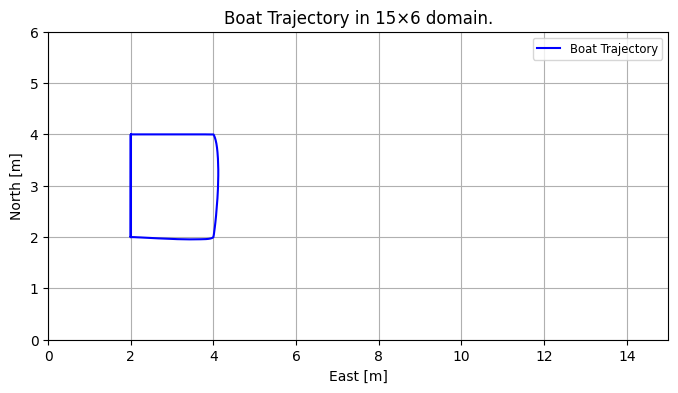

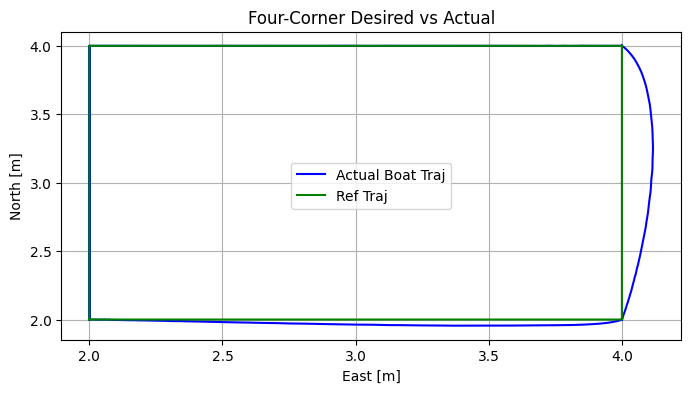

Simulation complete.


In [5]:
env.plot_trajectory()
print("Simulation complete.")


In [6]:
env.close()